# Project 2 - Dimensionality Reduction

In this project, you will work with various imagery dataset. You will implement dimensionality reduction and manifold learning techniques for visualization and subsequent classification tasks to report on a set of questions.

The goal of this project includes:

1. Dataset visualization and interpretability via dimensionality reduction
2. Implement dimensionality reduction techniques with ``scikit-learn``
3. Carry out experiments to select best subspace projections
4. Design pipelines for hyperparameter tuning and model selection
5. Implement performance evaluation metrics and evaluate results
6. Report observations, propose business-centric solutions and propose mitigating strategies

## Deliverables

As part of this project, you should deliver the following materials:

1. [**4-page IEEE-format paper**](https://www.ieee.org/conferences/publishing/templates.html). Write a paper with no more than 4 pages addressing the **``tasks``** posed below. When writing this report, consider a business-oriented person as your reader (e.g. your PhD advisor, your internship manager, etc.). Tell *the story* for each datasets' goal and propose solutions by addressing (at least) the **``tasks posed below``**.

2. **Python Code**. Create two separate Notebooks: (1) "training.ipynb" used for training and hyperparameter tuning, (2) "test.ipynb" for evaluating the final trained model in the test set. The "test.ipynb" should load all trained objects and simply evaluate the performance. So don't forget to **push the trained models** to your repository to allow us to run it.

All of your code should run without any errors and be well-documented.

3. **README.md file**. Edit the readme.md file in your repository and how to use your code. If there are user-defined parameters, your readme.md file must clearly indicate so and demonstrate how to use your code.

This is an **individual assignment**.

These deliverables are **due Monday, March 31 @ 11:59pm**. Late submissions will not be accepted, so please plan accordingly.

---

# Step 1. Choose One of the Following Public Datasets


Pick one of these five datasets (all multi-class). Download and explore its structure/documentation as needed:

## CIFAR-10

[Description](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data): Contains 60,000 32×32 color images in 10 classes (e.g., airplane, car, bird, cat, deer, dog, frog, horse, ship, truck).

For downloading, refer to step 2 examples

## MNIST

[Description](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data): A dataset of 70,000 handwritten digits (0–9), each image is 28×28 grayscale.

For downloading, refer to step 2 examples

## Fashion-MNIST

[Description](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data): Contains 70,000 images of fashion items (10 classes: T-Shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot), each 28×28 grayscale.

For downloading, refer to step 2 examples


You will use all classes in whichever dataset you pick, treating it as a multi-class classification problem.

---

# **Step 2. Data Preparation and Initial Visualization**  

- Download your dataset and split it into training (80%) and set (20%)
- Preprocessing steps may include:

    - Reshaping images into a 2D array if needed (e.g., for MNIST or Fashion-MNIST, each image is 28×28—reshape into a single 784-dimensional vector per sample if your model needs it).
    - Normalizing pixel values (e.g., scale them to [0, 1] or [-1, 1]).
    - Handling color images (like CIFAR-10, which are 32×32×3). You can flatten to a single 3,072-dimensional vector or keep the 2D+color structure if your library supports it.

- Below you can visualize some samples from each class

**``Task 1. Provide a summary of findings from the exploratory data analysis (bullet points or short analysis).``**

**``Task 2. Provide at least three visualizations showing trends or insights from the dataset.``**  

**``Task 3. Provide a written summary of the preprocessing steps.``**  




## HiperGator With 32 CPU


### CIFAR-10

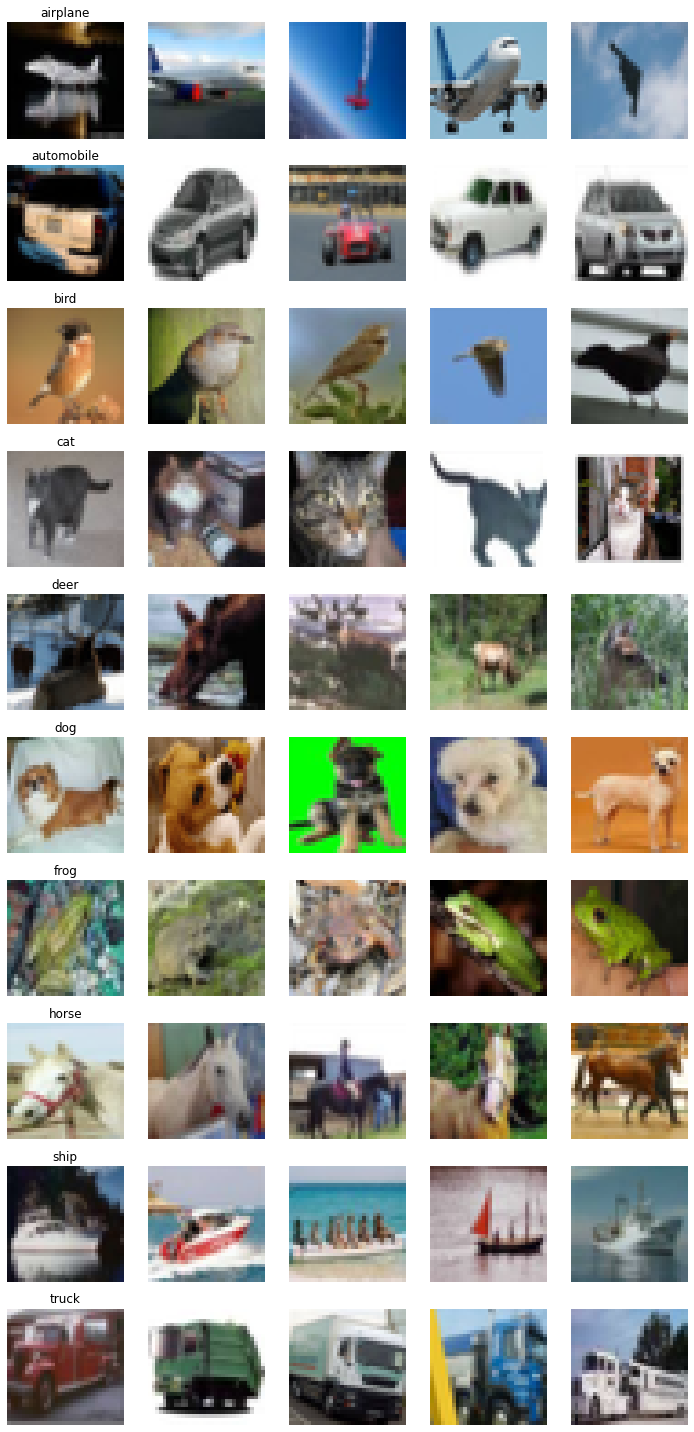

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR-10 has 10 classes
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def visualize_cifar10_samples(X, y, class_names, samples_per_class=5):
    """
    Displays a grid of sample images for each class in CIFAR-10.
    X: image array, shape (N, 32, 32, 3)
    y: labels array, shape (N, 1)
    class_names: list of 10 class names
    samples_per_class: how many examples to show per class
    """
    y = y.squeeze()  # Convert from shape (N,1) to (N,) if needed
    num_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 2, num_classes * 2))
    for cls_idx in range(num_classes):
        idxs = np.flatnonzero(y == cls_idx)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt.subplot(num_classes, samples_per_class, cls_idx * samples_per_class + i + 1)
            plt.imshow(X[idx])
            plt.axis('off')
            if i == 0:
                plt.title(class_names[cls_idx])
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_cifar10_samples(X_train, y_train, class_names)


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
import joblib
from sklearn.preprocessing import FunctionTransformer
# Preprocess data
def preprocess_data(X):
    # Reshape images to 2D (flattened)
    X_reshaped = X.reshape(X.shape[0], -1)
    # Normalize to [0, 1]
    X_normalized = X_reshaped / 255.0
    return X_normalized

preprocess_transformer = FunctionTransformer(
    preprocess_data,
    validate=False
)

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocess_transformer),
])





# Preprocess training and test data
X_train_preprocessed = preprocess_data(X_train)
X_test_preprocessed = preprocess_data(X_test)

# Convert labels from 2D to 1D
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Split the training data into 80% train and 20% validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_preprocessed, y_train, test_size=0.2, random_state=42
)

print("Preprocessed training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test_preprocessed.shape)

# Save preprocessing pipeline
preprocessing_pipeline = {'preprocess_function': preprocess_data}

joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')

Preprocessed training data shape: (50000, 32, 32, 3)
Validation data shape: (10000, 3072)
Test data shape: (10000, 3072)


['preprocessing_pipeline.pkl']

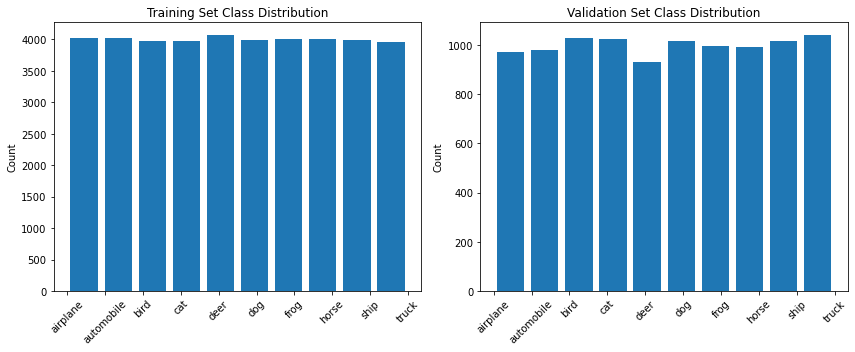

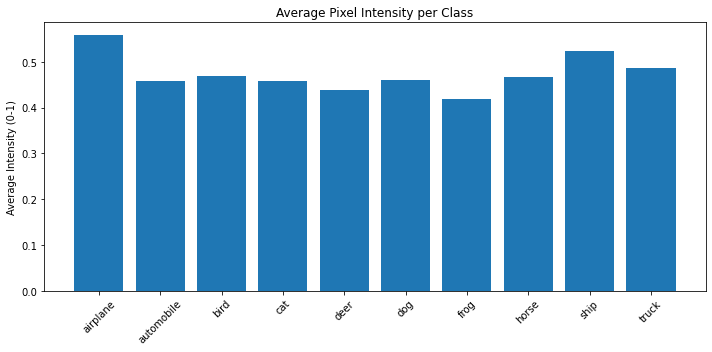

In [ ]:
# Class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Training Set Class Distribution')
plt.hist(y_train_split, bins=len(class_names), rwidth=0.8, align='mid')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.title('Validation Set Class Distribution')
plt.hist(y_val, bins=len(class_names), rwidth=0.8, align='mid')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Average pixel intensity per class
avg_intensity_per_class = []
for class_idx in range(len(class_names)):
    class_samples = X_train_split[y_train_split == class_idx]
    avg_intensity = np.mean(class_samples)
    avg_intensity_per_class.append(avg_intensity)

plt.figure(figsize=(10, 5))
plt.bar(class_names, avg_intensity_per_class)
plt.title('Average Pixel Intensity per Class')
plt.ylabel('Average Intensity (0-1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Step 3: Initial Classification (No Dimensionality Reduction)**  


1. **Models to Explore:**

    - Support Vector Classifier (SVC)
    - Random Forest
    - Logistic Regression (multi-class)


2. **Hyperparameter Tuning:**

    - For SVC (multi-class in ``scikit-learn`` typically “one-vs-one” or “one-vs-rest” under the hood):
    
        - ``kernel``: [“rbf”, “linear”]
        - ``C``: e.g. [0.1, 1, 10]
        - ``gamma``: [“scale”, “auto”] (if using RBF)
        
    - For Random Forest:**
    
        - ``n_estimators``: e.g. [50, 100, 200]
        - ``max_depth``: [None, 5, 10]

    - For Logistic Regression:**
    
        - ``penalty``: [“l2”]
        - ``solver``: [“saga”, “lbfgs”]
        - ``C``: [0.01, 0.1, 1, 10]
        - ``max_iter``: e.g. [100, 200, 500]
        

3. **Model Training and Metrics:**

    - Record accuracy and F1-score (macro-F1 is often used for multi-class).
    - Training time: measure how long it takes to train each model.
    
**``Task 4. Clearly report best hyperparameter set per model and metrics``**




In [ ]:
# Create smaller subset for faster hyperparameter tuning
# Select 2500 random samples
indices = np.random.choice(len(X_train_split), 2500, replace=False)
X_subset = X_train_split[indices]
y_subset = y_train_split[indices]

## Support Vector Classifier(SVC)

Training SVC model...
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Training time: 22.41 seconds
Evaluating best model from grid search on validation set...
SVC Results:
Accuracy: 0.4169
F1 Score (Macro): 0.4160
Inference Time: 81.4416 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.43      0.47      0.45       973
  automobile       0.44      0.59      0.51       979
        bird       0.31      0.28      0.29      1030
         cat       0.29      0.32      0.31      1023
        deer       0.35      0.42      0.38       933
         dog       0.34      0.30      0.32      1015
        frog       0.45      0.43      0.44       996
       horse       0.51      0.36      0.42       994
        ship       0.56      0.56      0.56      1017
       truck       0.52      0.44      0.48      1040

    accuracy                           0.42 

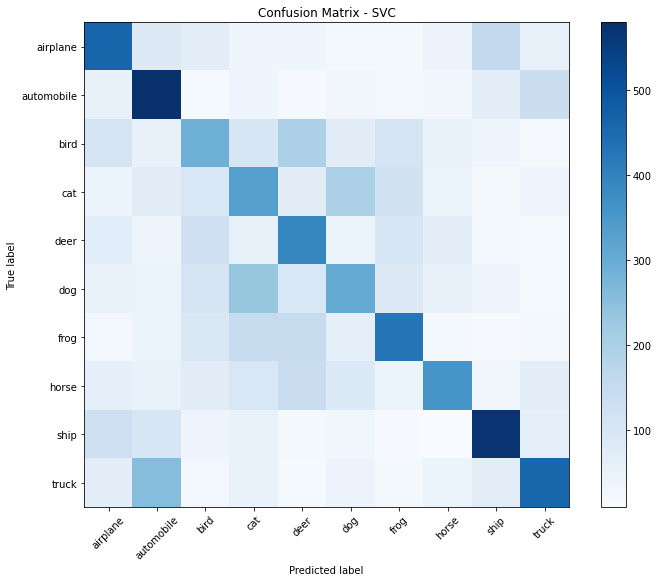

['best_SVC_model.pkl']

In [ ]:
print("Training SVC model...")
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

svc_param_grid = {
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

svc_grid = GridSearchCV(svc_pipeline, svc_param_grid, cv=2, n_jobs=-1, verbose=1)
start_time = time.time()
svc_grid.fit(X_subset, y_subset)
svc_train_time = time.time() - start_time

print(f"Best parameters: {svc_grid.best_params_}")
print(f"Training time: {svc_train_time:.2f} seconds")

# Use the best model from GridSearchCV directly
print("Evaluating best model from grid search on validation set...")
start_time = time.time()
y_pred_svc = svc_grid.predict(X_val)
svc_inference_time = time.time() - start_time

svc_accuracy = accuracy_score(y_val, y_pred_svc)
svc_f1 = f1_score(y_val, y_pred_svc, average='macro')

print("SVC Results:")
print(f"Accuracy: {svc_accuracy:.4f}")
print(f"F1 Score (Macro): {svc_f1:.4f}")
print(f"Inference Time: {svc_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svc, target_names=class_names))

# Confusion matrix
cm_svc = confusion_matrix(y_val, y_pred_svc)
plt.figure(figsize=(10, 8))
plt.imshow(cm_svc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVC')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model
joblib.dump(svc_grid.best_estimator_, 'best_SVC_model.pkl')

## Random Forest

Training Random Forest model...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Training time: 173.00 seconds

Retraining best model on full dataset...
Full training time: 14.95 seconds
Optimized Random Forest Results:
Accuracy: 0.4692
F1 Score (Macro): 0.4649
Inference Time: 0.4081 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.53      0.52      0.52       973
  automobile       0.49      0.53      0.51       979
        bird       0.40      0.31      0.35      1030
         cat       0.39      0.29      0.33      1023
        deer       0.37      0.42      0.40       933
         dog       0.41      0.38      0.39      1015
        frog       0.46      0.57      0.51       996
       horse       0.52      0.47      0.49       994
        ship       0.59      0.61      0.60      1017
       truck       0.51      0.59   

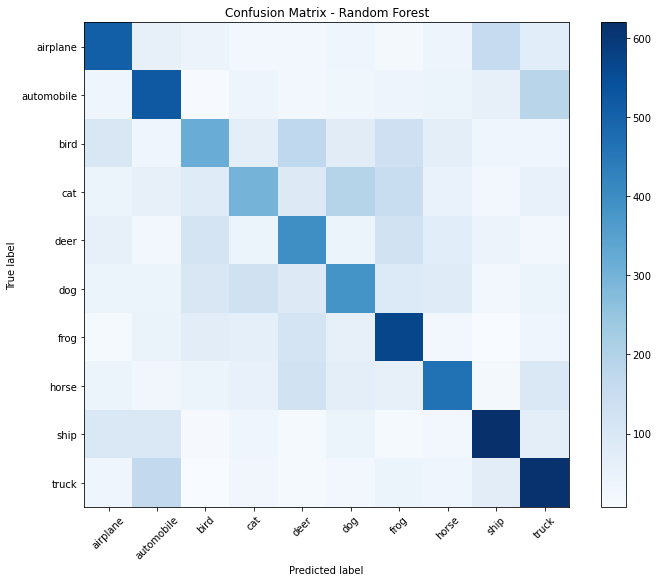

['best_rf_model.pkl']

In [ ]:
print("Training Random Forest model...")

rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        verbose=0
    ))
])


rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__max_features': ['sqrt', 0.8]
}


rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)


start_time = time.time()
rf_grid.fit(X_subset, y_subset)
rf_train_time = time.time() - start_time

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Training time: {rf_train_time:.2f} seconds")

best_rf = rf_grid.best_estimator_

# Use the best model from GridSearchCV directly
print("\nRetraining best model on full dataset...")
start_time = time.time()
best_rf.fit(X_train_split, y_train_split)
rf_full_train_time = time.time() - start_time
print(f"Full training time: {rf_full_train_time:.2f} seconds")

# evaluate
start_time = time.time()
y_pred_rf = best_rf.predict(X_val)
rf_inference_time = time.time() - start_time

rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf, average='macro')

print("Optimized Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score (Macro): {rf_f1:.4f}")
print(f"Inference Time: {rf_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=class_names))

# Confusion matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(10, 8))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model
joblib.dump(best_rf, 'best_rf_model.pkl', compress=3)

## Logistic Regression(Multi-Class)

Training Logistic Regression model...
Fitting 2 folds for each of 24 candidates, totalling 48 fits


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters: {'lr__C': 0.01, 'lr__max_iter': 100, 'lr__solver': 'saga'}
Training time: 162.93 seconds
Logistic Regression Results:
Accuracy: 0.3337
F1 Score (Macro): 0.3325
Inference Time: 0.1283 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.38      0.39      0.38       973
  automobile       0.37      0.41      0.39       979
        bird       0.23      0.20      0.21      1030
         cat       0.24      0.27      0.25      1023
        deer       0.25      0.30      0.27       933
         dog       0.28      0.24      0.26      1015
        frog       0.37      0.40      0.38       996
       horse       0.39      0.30      0.34       994
        ship       0.42      0.46      0.44      1017
       truck       0.42      0.39      0.40      1040

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.33      0.33      0.33     10000



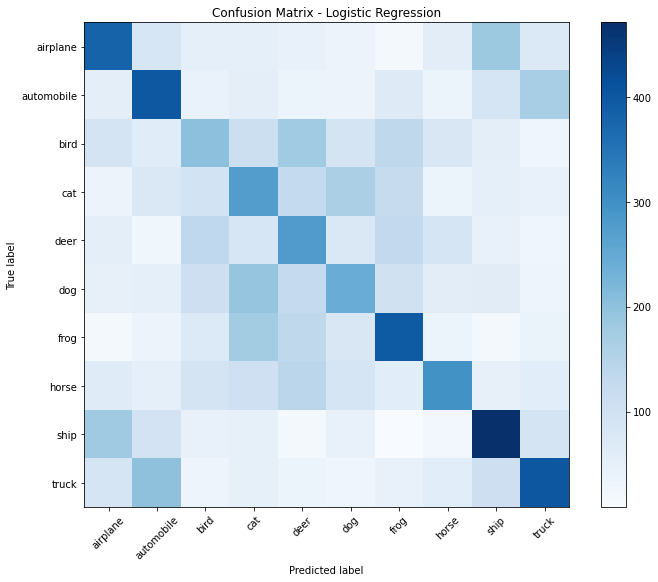

['best_lr_model.pkl']

In [ ]:
print("Training Logistic Regression model...")
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10],  # Reduced parameter options
    'lr__solver': ['saga', 'lbfgs'],  # Added missing comma here
    'lr__max_iter': [100, 200, 500]  # Fixed parameter name
}

lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=2, n_jobs=-1, verbose=1)
start_time = time.time()
lr_grid.fit(X_subset, y_subset)
lr_train_time = time.time() - start_time

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Training time: {lr_train_time:.2f} seconds")

# Use the best model from GridSearchCV directly
start_time = time.time()
y_pred_lr = lr_grid.predict(X_val)
lr_inference_time = time.time() - start_time

lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1 = f1_score(y_val, y_pred_lr, average='macro')

print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score (Macro): {lr_f1:.4f}")
print(f"Inference Time: {lr_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr, target_names=class_names))

# Confusion matrix
cm_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(10, 8))
plt.imshow(cm_lr, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model
joblib.dump(lr_grid.best_estimator_, 'best_lr_model.pkl', compress=3)

## Compare

In [ ]:
# Compare tuned models
baseline_results = pd.DataFrame({
    'Model': ['SVC', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [svc_accuracy, rf_accuracy, lr_accuracy],
    'F1 Score': [svc_f1, rf_f1, lr_f1],
    'Training Time (s)': [svc_train_time, rf_train_time, lr_train_time],
    'Inference Time (s)': [svc_inference_time, rf_inference_time, lr_inference_time],
    'Best Parameters': [
        str({k.replace('svc__', ''): v for k, v in svc_grid.best_params_.items()}),
        str({k.replace('rf__', ''): v for k, v in rf_grid.best_params_.items()}),
        str({k.replace('lr__', ''): v for k, v in lr_grid.best_params_.items()})
    ]
})

print("Baseline Models (No Dimensionality Reduction)")
print(baseline_results)


Baseline Models (No Dimensionality Reduction)
                 Model  Accuracy  F1 Score  Training Time (s)  \
0                  SVC    0.4169  0.415975          22.408150   
1        Random Forest    0.4692  0.464919         173.004491   
2  Logistic Regression    0.3337  0.332471         162.928465   

   Inference Time (s)                                    Best Parameters  
0           81.441629       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
1            0.408138  {'max_depth': None, 'max_features': 'sqrt', 'n...  
2            0.128320     {'C': 0.01, 'max_iter': 100, 'solver': 'saga'}  


----

## **Step 4: PCA Dimensionality Reduction**  


1. Train a ``pipeline`` to perform dimensionality reduction with Principal Component Analysis (PCA). Answer the following questions:

    - How many components are needed to explain 90% of the variance?
    - Visualize examples of image reconstructions. What is the average RMSE of the reconstruction as a function of number of components preserved?
    
2. Train a ``pipeline`` for the same classifiers in part (1) with dimensionality reduction via PCA.

    - Carry the standard hyperparameter tuning (including ``n_components``).
    - Compare performance measures and training time.

3. Repeat question (3) for using manifold learning algorithms. Utilize the new lower-dimensional feature space to build a classifier.

    - Use the same classifiers.
    - Compare performance metrics and training/inference time with those for question (3) and (1).
    - Visualize and interpret what the first 2 dimensions in the manifold learning algorithms you train. Use the ``plot_components`` function presented in lecture.

4. What is the overall best ``pipeline``?
    - Report the confusion matrices.
    - Visualize misclassified samples. Do you see a pattern? Provide a discussion on how you would move forward to address the misclassifications.
    
**``Task 5. Clearly report insights about items 1-4 in this step``**

---

Calculating PCA components for 90% variance...


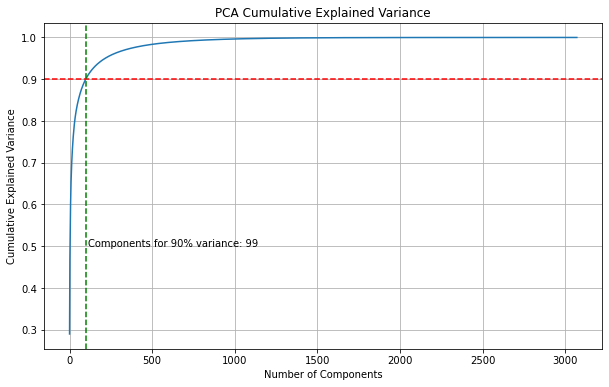

Number of components needed for 90% of variance: 99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


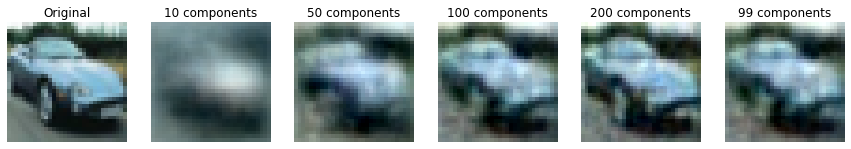

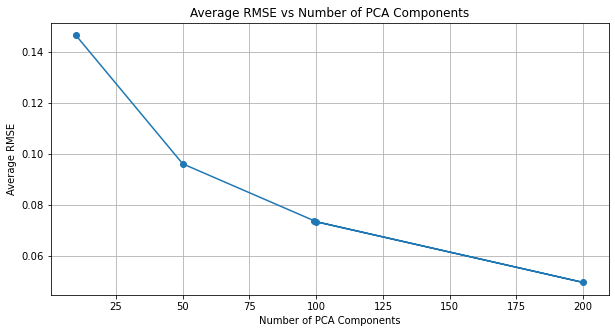

Components: 10, RMSE: 0.1465
Components: 50, RMSE: 0.0960
Components: 100, RMSE: 0.0733
Components: 200, RMSE: 0.0495
Components: 99, RMSE: 0.0735


In [ ]:
# Fit PCA to determine number of components for 90% variance
print("Calculating PCA components for 90% variance...")
pca = PCA()
pca.fit(X_train_split)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axvline(x=n_components_90, color='g', linestyle='--')
plt.text(n_components_90 + 10, 0.5, f'Components for 90% variance: {n_components_90}')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.show()

print(f"Number of components needed for 90% of variance: {n_components_90}")

# Visualize image reconstructions with a small subset
def visualize_pca_reconstruction(X, n_components_list):
    plt.figure(figsize=(15, 8))
    rmse_values = []

    # Choose a random sample to visualize
    sample_idx = np.random.randint(0, X.shape[0])
    original_img = X[sample_idx].reshape(32, 32, 3)

    # Plot the original image
    plt.subplot(2, len(n_components_list) + 1, 1)
    plt.imshow(original_img)
    plt.title('Original')
    plt.axis('off')

    # For each number of components, reconstruct and calculate RMSE
    for i, n_comp in enumerate(n_components_list):
        pca = PCA(n_components=n_comp)
        X_reduced = pca.fit_transform(X)
        X_reconstructed = pca.inverse_transform(X_reduced)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((X - X_reconstructed) ** 2))
        rmse_values.append(rmse)

        # Plot the reconstructed image
        reconstructed_img = X_reconstructed[sample_idx].reshape(32, 32, 3)
        plt.subplot(2, len(n_components_list) + 1, i + 2)
        plt.imshow(reconstructed_img)
        plt.title(f'{n_comp} components')
        plt.axis('off')

    # Plot RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(n_components_list, rmse_values, marker='o')
    plt.grid(True)
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE vs Number of PCA Components')
    plt.show()

    return rmse_values

# Test with different numbers of components - using small subset for speed
X_small_subset = X_train_preprocessed[:1000]
n_components_list = [10, 50, 100, 200, n_components_90]
rmse_values = visualize_pca_reconstruction(X_small_subset, n_components_list)

# Print RMSE values
for n_comp, rmse in zip(n_components_list, rmse_values):
    print(f"Components: {n_comp}, RMSE: {rmse:.4f}")


## SVC with PCA

Training PCA + SVC model...
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'pca__n_components': 100, 'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Training time: 39.98 seconds
PCA + SVC Results:
Accuracy: 0.3967
F1 Score (Macro): 0.3917
Inference Time: 2.5904 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.43      0.47      0.45       973
  automobile       0.41      0.53      0.46       979
        bird       0.29      0.20      0.24      1030
         cat       0.30      0.28      0.29      1023
        deer       0.31      0.45      0.36       933
         dog       0.38      0.30      0.33      1015
        frog       0.39      0.48      0.43       996
       horse       0.51      0.28      0.36       994
        ship       0.49      0.55      0.52      1017
       truck       0.51      0.44      0.47      1040

    accuracy                           0.40     10000
   macro avg  

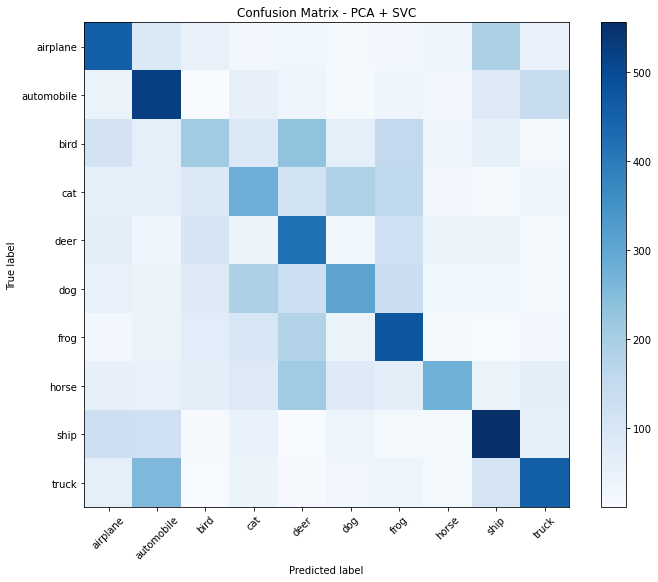

['best_pca_svc_model.pkl']

In [ ]:
print("Training PCA + SVC model...")
pca_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC(random_state=42))
])

pca_svc_param_grid = {
    'pca__n_components': [50, 100, n_components_90],  # Reduced parameter options
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': [0.1, 1],
    'svc__gamma': ['scale']
}

pca_svc_grid = GridSearchCV(pca_svc_pipeline, pca_svc_param_grid, cv=2, n_jobs=-1, verbose=1)
start_time = time.time()
pca_svc_grid.fit(X_subset, y_subset)
pca_svc_train_time = time.time() - start_time

print(f"Best parameters: {pca_svc_grid.best_params_}")
print(f"Training time: {pca_svc_train_time:.2f} seconds")

# Evaluate on validation set
start_time = time.time()
y_pred_pca_svc = pca_svc_grid.predict(X_val)
pca_svc_inference_time = time.time() - start_time

pca_svc_accuracy = accuracy_score(y_val, y_pred_pca_svc)
pca_svc_f1 = f1_score(y_val, y_pred_pca_svc, average='macro')

print("PCA + SVC Results:")
print(f"Accuracy: {pca_svc_accuracy:.4f}")
print(f"F1 Score (Macro): {pca_svc_f1:.4f}")
print(f"Inference Time: {pca_svc_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_pca_svc, target_names=class_names))

# Confusion matrix
cm_pca_svc = confusion_matrix(y_val, y_pred_pca_svc)
plt.figure(figsize=(10, 8))
plt.imshow(cm_pca_svc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - PCA + SVC')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model

joblib.dump(pca_svc_grid, 'best_pca_svc_model.pkl', compress=3)

## Random Forest with PCA

Training PCA + Random Forest model...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best parameters: {'pca__n_components': 50, 'rf__max_depth': 20, 'rf__n_estimators': 100}
Training time: 4.39 seconds
PCA + Random Forest Results:
Accuracy: 0.3605
F1 Score (Macro): 0.3526
Inference Time: 0.3358 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.42      0.46      0.44       973
  automobile       0.34      0.52      0.42       979
        bird       0.27      0.19      0.22      1030
         cat       0.26      0.25      0.25      1023
        deer       0.30      0.42      0.35       933
         dog       0.35      0.22      0.27      1015
        frog       0.36      0.45      0.40       996
       horse       0.43      0.23      0.30       994
        ship       0.45      0.52      0.48      1017
       truck       0.44      0.37      0.40      1040

    accuracy                           0.36     10000
   macro 

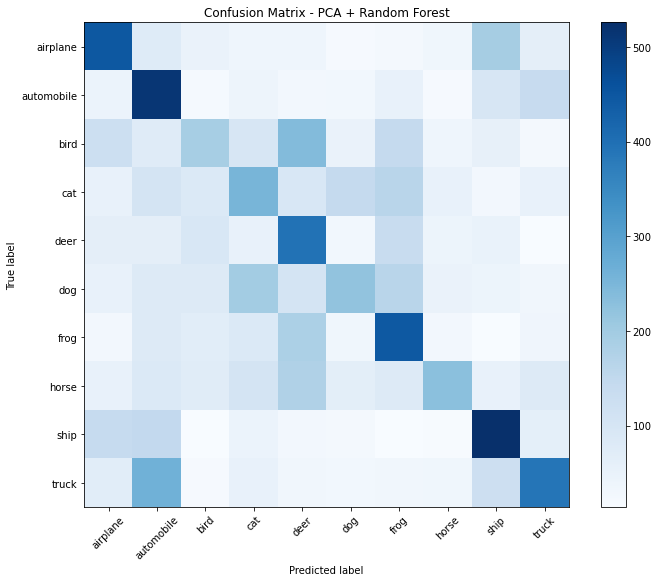

['best_pca_rf_grid_model.pkl']

In [ ]:
print("Training PCA + Random Forest model...")
pca_rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42))
])

pca_rf_param_grid = {
    'pca__n_components': [50, 100, n_components_90],
    'rf__n_estimators': [100],
    'rf__max_depth': [10, 20]
}

pca_rf_grid = GridSearchCV(pca_rf_pipeline, pca_rf_param_grid, cv=2, n_jobs=-1, verbose=1)
start_time = time.time()
pca_rf_grid.fit(X_subset, y_subset)
pca_rf_train_time = time.time() - start_time

print(f"Best parameters: {pca_rf_grid.best_params_}")
print(f"Training time: {pca_rf_train_time:.2f} seconds")

# Evaluate on validation set
start_time = time.time()
y_pred_pca_rf = pca_rf_grid.predict(X_val)
pca_rf_inference_time = time.time() - start_time

pca_rf_accuracy = accuracy_score(y_val, y_pred_pca_rf)
pca_rf_f1 = f1_score(y_val, y_pred_pca_rf, average='macro')

print("PCA + Random Forest Results:")
print(f"Accuracy: {pca_rf_accuracy:.4f}")
print(f"F1 Score (Macro): {pca_rf_f1:.4f}")
print(f"Inference Time: {pca_rf_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_pca_rf, target_names=class_names))

# Confusion matrix
cm_pca_rf = confusion_matrix(y_val, y_pred_pca_rf)
plt.figure(figsize=(10, 8))
plt.imshow(cm_pca_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - PCA + Random Forest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model
joblib.dump(pca_rf_grid, 'best_pca_rf_grid_model.pkl', compress=3)

## Logistic Regression with PCA

Training PCA + Logistic Regression model...
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'lr__C': 1, 'lr__solver': 'saga', 'pca__n_components': 50}
Training time: 9.22 seconds
PCA + Logistic Regression Results:
Accuracy: 0.3404
F1 Score (Macro): 0.3368
Inference Time: 0.1772 seconds

Classification Report:
              precision    recall  f1-score   support

    airplane       0.39      0.41      0.40       973
  automobile       0.32      0.41      0.36       979
        bird       0.26      0.19      0.22      1030
         cat       0.26      0.29      0.27      1023
        deer       0.29      0.31      0.30       933
         dog       0.33      0.23      0.27      1015
        frog       0.34      0.42      0.38       996
       horse       0.37      0.28      0.32       994
        ship       0.42      0.46      0.44      1017
       truck       0.42      0.40      0.41      1040

    accuracy                           0.34     10000
   macro

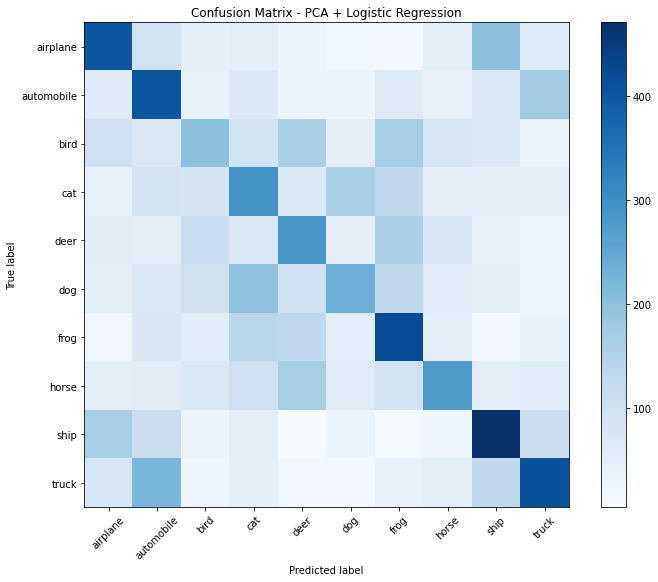

['best_pca_lr_grid_model.pkl']

In [ ]:
print("Training PCA + Logistic Regression model...")
pca_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

pca_lr_param_grid = {
    'pca__n_components': [50, 100, n_components_90],
    'lr__C': [0.1, 1],
    'lr__solver': ['saga', 'lbfgs']
}

pca_lr_grid = GridSearchCV(pca_lr_pipeline, pca_lr_param_grid, cv=2, n_jobs=-1, verbose=1)
start_time = time.time()
pca_lr_grid.fit(X_subset, y_subset)
pca_lr_train_time = time.time() - start_time

print(f"Best parameters: {pca_lr_grid.best_params_}")
print(f"Training time: {pca_lr_train_time:.2f} seconds")

# Evaluate on validation set
start_time = time.time()
y_pred_pca_lr = pca_lr_grid.predict(X_val)
pca_lr_inference_time = time.time() - start_time

pca_lr_accuracy = accuracy_score(y_val, y_pred_pca_lr)
pca_lr_f1 = f1_score(y_val, y_pred_pca_lr, average='macro')

print("PCA + Logistic Regression Results:")
print(f"Accuracy: {pca_lr_accuracy:.4f}")
print(f"F1 Score (Macro): {pca_lr_f1:.4f}")
print(f"Inference Time: {pca_lr_inference_time:.4f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_pca_lr, target_names=class_names))

# Confusion matrix
cm_pca_lr = confusion_matrix(y_val, y_pred_pca_lr)
plt.figure(figsize=(10, 8))
plt.imshow(cm_pca_lr, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - PCA + Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model

joblib.dump(pca_lr_grid, 'best_pca_lr_grid_model.pkl', compress=3)

In [ ]:
pca_results = pd.DataFrame({
    'Model': ['PCA + SVC', 'PCA + Random Forest', 'PCA + Logistic Regression'],
    'Accuracy': [pca_svc_accuracy, pca_rf_accuracy, pca_lr_accuracy],
    'F1 Score': [pca_svc_f1, pca_rf_f1, pca_lr_f1],
    'Training Time (s)': [pca_svc_train_time, pca_rf_train_time, pca_lr_train_time],
    'Inference Time (s)': [pca_svc_inference_time, pca_rf_inference_time, pca_lr_inference_time],
    'PCA Components': [
        pca_svc_grid.best_params_['pca__n_components'],
        pca_rf_grid.best_params_['pca__n_components'],
        pca_lr_grid.best_params_['pca__n_components']
    ]
})

print("Models with PCA Dimensionality Reduction")
print(pca_results)

Models with PCA Dimensionality Reduction
                       Model  Accuracy  F1 Score  Training Time (s)  \
0                  PCA + SVC    0.3967  0.391745          39.982142   
1        PCA + Random Forest    0.3605  0.352634           4.392016   
2  PCA + Logistic Regression    0.3404  0.336801           9.220447   

   Inference Time (s)  PCA Components  
0            2.590395             100  
1            0.335762              50  
2            0.177243              50  


## Manifold Learning

In [ ]:
# Function to plot 2D embedding of data
def plot_components(X_reduced, y, title="", figsize=(12, 10)):
    plt.figure(figsize=figsize)

    # Use a subset for visualization
    n_samples = min(2000, X_reduced.shape[0])
    if X_reduced.shape[0] > n_samples:
        indices = np.random.choice(X_reduced.shape[0], n_samples, replace=False)
        X_reduced = X_reduced[indices]
        y = y[indices]

    for i, label in enumerate(class_names):
        plt.scatter(
            X_reduced[y == i, 0], X_reduced[y == i, 1],
            alpha=0.5, label=label
        )

    plt.legend(loc="best")
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.show()

# Use a small subset for manifold learning techniques (they can be slow)
X_manifold_subset = X_train_split[:2000]
y_manifold_subset = y_train_split[:2000]

Applying t-SNE for visualization...
t-SNE transformation time: 4.66 seconds


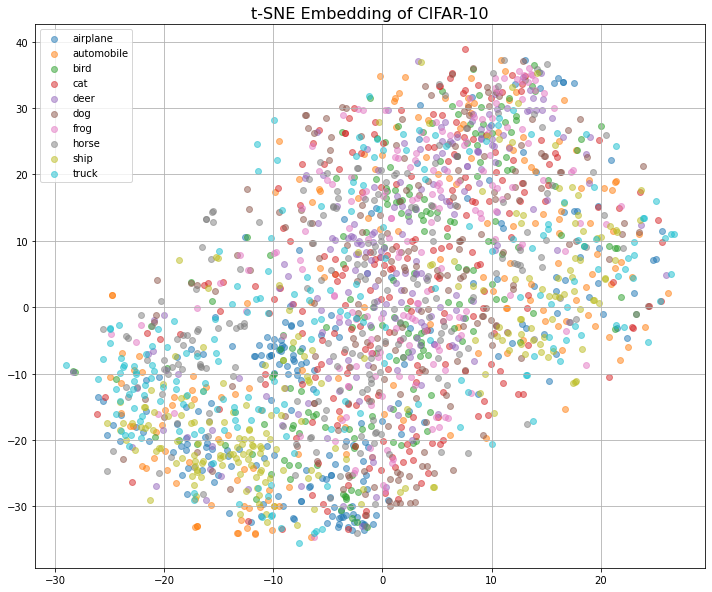

In [ ]:
# 5.1: t-SNE visualization
#------------------------------------
print("Applying t-SNE for visualization...")
start_time = time.time()
X_scaled = StandardScaler().fit_transform(X_manifold_subset)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
tsne_time = time.time() - start_time
print(f"t-SNE transformation time: {tsne_time:.2f} seconds")

# Plot t-SNE
plot_components(X_tsne, y_manifold_subset, "t-SNE Embedding of CIFAR-10")

Applying Isomap for visualization...
Isomap transformation time: 2.33 seconds


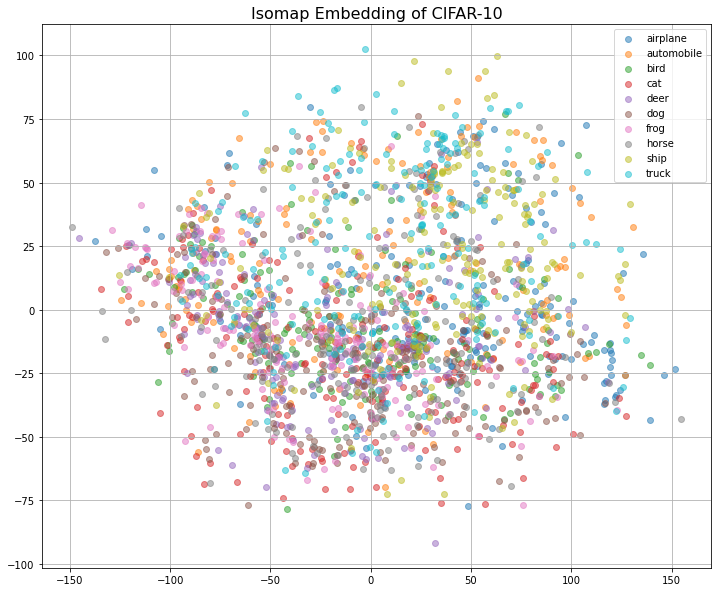

In [ ]:
# 5.2: Isomap visualization
#------------------------------------
print("Applying Isomap for visualization...")
start_time = time.time()
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_scaled)
isomap_time = time.time() - start_time
print(f"Isomap transformation time: {isomap_time:.2f} seconds")

# Plot Isomap
plot_components(X_isomap, y_manifold_subset, "Isomap Embedding of CIFAR-10")

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_test.shape

(10000,)

In [ ]:
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [ ]:
joblib.dump(X_test, 'X_test.pkl')

['X_test.pkl']


Addressing Misclassifications
Misclassifications are inevitable in machine learning, but we can employ various techniques to minimize them and improve model performance. Based on the confusion matrices and analysis of misclassified samples, consider the following strategies:

1. Data Augmentation:

Rationale: Increasing the size and diversity of the training dataset can improve the model's ability to generalize and reduce overfitting, leading to better performance on unseen data.
Techniques: Apply transformations like rotations, flips, crops, and color adjustments to existing images to create new training samples. Explore advanced augmentation techniques like Mixup or CutMix.
2. Feature Engineering:

Rationale: Extracting more informative features or transforming existing features can enhance the model's ability to discriminate between classes.
Techniques: Explore domain-specific feature extraction methods for image data, such as edge detection, texture analysis, or color histograms. Consider using pre-trained convolutional neural networks (CNNs) to extract features.
3. Hyperparameter Optimization:

Rationale: Fine-tuning model hyperparameters can significantly impact performance. Explore a wider range of hyperparameter values and utilize more sophisticated optimization techniques.
Techniques: Employ Bayesian optimization or genetic algorithms for hyperparameter search. Consider using cross-validation to evaluate performance across different hyperparameter settings.
4. Model Ensemble:

Rationale: Combining predictions from multiple models can often improve overall accuracy and robustness.
Techniques: Create an ensemble of different classifiers (e.g., SVC, Random Forest, Logistic Regression) or train multiple instances of the same model with different initializations or hyperparameters. Use techniques like bagging or boosting to combine predictions.


Iterative Approach: Apply these strategies iteratively, evaluating the impact of each change on model performance. Monitor progress using appropriate metrics and visualizations.
Focus on Problematic Classes: Prioritize addressing misclassifications related to specific classes that are crucial for the application.
Data Quality: Ensure the quality and relevance of the training data. Clean and label the data carefully to minimize errors and inconsistencies.